# OLED Optimization with FourierFields


In [7]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [8]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

sim = []

for i in range(src_num):
    sim.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[sources[i]],
                      extra_materials=[ALU],)
    )

                    

<Axes: xlabel='X', ylabel='Y'>

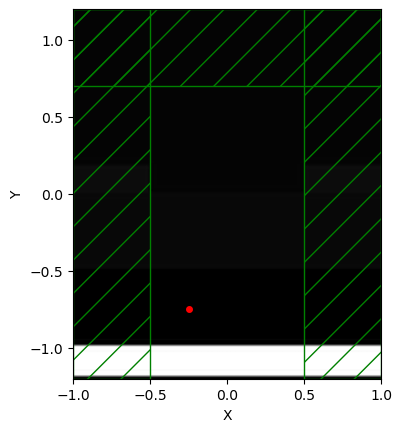

In [9]:
sim[0].plot2D()

<Axes: xlabel='X', ylabel='Y'>

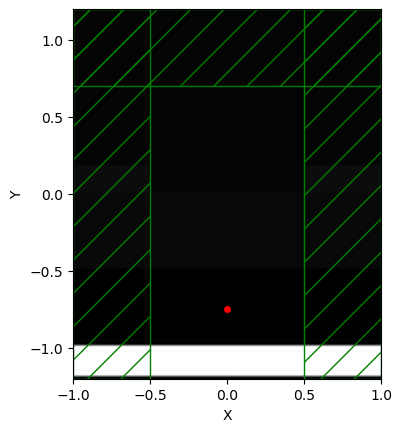

In [10]:
sim[1].plot2D()

<Axes: xlabel='X', ylabel='Y'>

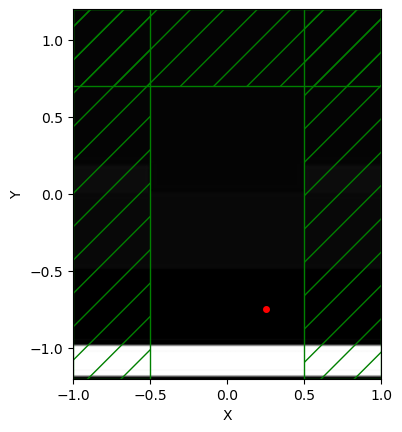

In [11]:
sim[2].plot2D()

In [12]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)

FourierFields = []
for i in range(src_num):
    FourierFields.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True))
ob_list = []
for i in range(src_num):
    ob_list.append([FourierFields[i]])

def J_directional(fields):
    # fields: shape (Nk, Ny), Ny=1 in our 2D sim
    Ez_kx = fields[:, 0]  # flatten to 1D
    
    Nx = Ez_kx.shape[0]
    dx = cell_size.x / Nx
    kx_vals = 2 * np.pi * np.fft.fftfreq(Nx, d=dx)

    k0 = 2 * np.pi * fcen
    theta_max = np.radians(0.5)
    kx_max = k0 * np.sin(theta_max)

    # 방향성 필터
    mask = np.abs(kx_vals) <= kx_max
    Ez_directional = Ez_kx[mask]

    return -npa.mean(npa.abs(Ez_directional) ** 2)
opt = []
for i in range(src_num):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J_directional],
        objective_arguments=ob_list[i],
        design_regions=[design_region],
        frequencies=[fcen],
        maximum_run_time=100,
    ))

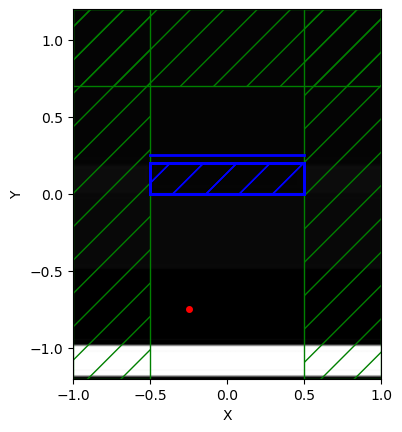

In [13]:
opt[0].plot2D(True)

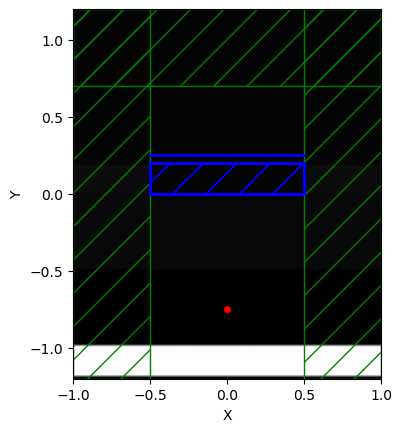

In [14]:
opt[1].plot2D(True)

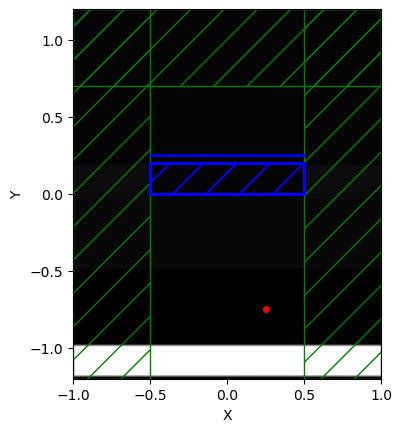

In [15]:
opt[2].plot2D(True)

In [16]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [17]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [18]:
evaluation_history = []
cur_iter = [0]
numevl = 1

def f(x, gradient):
    t = x[0]
    v = x[1:]
    if gradient.size > 0:
        gradient[0] = 1
        gradient[1:] = 0
    return t

def c(result, x, gradient, beta):

    print("Current iteration: {}".format(cur_iter[0] + 1))

    global numevl
    t=x[0]
    v=x[1:]
    f0 = []
    dJ_du = []

    for i in range(src_num):
        f0_i, dJ_du_i = opt[i]([mapping(v, eta_i, beta)])
        f0.append(f0_i.flatten())
        dJ_du.append(dJ_du_i)

    my_grad = np.zeros((Nx * Ny, src_num))

    for i in range(src_num):
        my_grad[:,i] = dJ_du[i]

    for k in range(src_num):
        my_grad[:,k] = tensor_jacobian_product(mapping,0)(
            v,
            eta_i,
            cur_beta,
            my_grad[:,k],
        )


    if gradient.size > 0:
        gradient[:, 0] = -1
        gradient[:, 1:] = my_grad.T

    result[:] = (np.real(f0) - t).reshape(-1)

    evaluation_history.append([np.max(np.real(f0[i])) for i in range(src_num)])
    
    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current f0 values: " + ", ".join(["f0_{}: {}".format(i, np.real(f0[i])) for i in range(src_num)]))


In [19]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

# insert dummy parameter bounds and variable
x = np.insert(x, 0, -1)  # our initial guess for the worst error
lb = np.insert(lb, 0, -np.inf) # lower bound for the error
ub = np.insert(ub, 0, 0) # upper bound for the error

# Optimization parameter
cur_beta = 4 # initial beta value
beta_scale = 1.5 # scaling factor for beta updates
num_betas = 9 # number of beta updates
tol_epi = np.array([1e-4] * 3) # tolerances for the epsilon constraints
update_factor = 12  # number of iterations between beta updates
ftol = 1e-5  # tolerance for the objective function

# Optimization
for iters in range(num_betas):
    print("current beta: ", cur_beta)
    solver = nlopt.opt(algorithm, n+1)
    solver.set_lower_bounds(lb) # lower bounds
    solver.set_upper_bounds(ub) # upper bounds
    solver.set_min_objective(f)
    solver.add_inequality_mconstraint(
        lambda rr, xx, gg: c(
            rr,
            xx,
            gg,
            cur_beta,
        ),
        tol_epi
    )
    solver.set_maxeval(update_factor) # Set the maximum number of function evaluations
        
    # solver.set_param("dual_ftol_rel", 1e-7)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale # Update the beta value for the next iteration


current beta:  4
Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.04703422], f0_1: [-0.05607162], f0_2: [-0.11595549]
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.04707351], f0_1: [-0.05610045], f0_2: [-0.11601964]
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.04746207], f0_1: [-0.05638436], f0_2: [-0.11665246]
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.05246423], f0_1: [-0.05990897], f0_2: [-0.12458048]
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.08506315], f0_1: [-0.08136521], f0_2: [-0.16704846]
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.1386697], f0_1: [-0.11352784], f0_2: [-0.20544873]
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.14411348], f0_1: [-0.11518297], f0_2: [-0.21937967]
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.14709497], f0_1: [-0.11536284], f0_2: [-0.23104117]
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.14962436], f0_1: [-0.11500492], f0_2: [-0.24279328]
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.15207417], f0_1: [-0.11432202], f0_2: [-0.25223381]
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.15420854], f0_1: [-0.11329551], f0_2: [-0.25871307]
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.15552192], f0_1: [-0.11228267], f0_2: [-0.26328936]
current beta:  6.0
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.04746207], f0_1: [-0.05638436], f0_2: [-0.11665246]
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.04749453], f0_1: [-0.05638696], f0_2: [-0.11666888]
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.04786515], f0_1: [-0.05641626], f0_2: [-0.11685556]
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.05303086], f0_1: [-0.05677916], f0_2: [-0.11932769]
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.08323883], f0_1: [-0.0814958], f0_2: [-0.12568908]
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.15325233], f0_1: [-0.14238014], f0_2: [-0.13691779]
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.16107938], f0_1: [-0.17180567], f0_2: [-0.16715934]
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.17775196], f0_1: [-0.17712514], f0_2: [-0.17753437]
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.1820981], f0_1: [-0.18218426], f0_2: [-0.1819149]
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18499147], f0_1: [-0.18473972], f0_2: [-0.18457854]
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.1868515], f0_1: [-0.18663814], f0_2: [-0.18656034]
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18811684], f0_1: [-0.18804049], f0_2: [-0.18798384]
current beta:  9.0
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18811684], f0_1: [-0.18804049], f0_2: [-0.18798384]
Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18810485], f0_1: [-0.1880332], f0_2: [-0.18800256]


Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18804796], f0_1: [-0.18804794], f0_2: [-0.18804802]
Current iteration: 28
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.1880881], f0_1: [-0.18808793], f0_2: [-0.18808781]
Current iteration: 29
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18833645], f0_1: [-0.18833352], f0_2: [-0.18832599]
Current iteration: 30
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18888885], f0_1: [-0.18885248], f0_2: [-0.18881903]
Current iteration: 31
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18943414], f0_1: [-0.18939086], f0_2: [-0.18936097]
Current iteration: 32
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.18992507], f0_1: [-0.18986658], f0_2: [-0.18984026]
Current iteration: 33
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19036693], f0_1: [-0.19031645], f0_2: [-0.19029272]
Current iteration: 34
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19071423], f0_1: [-0.19067422], f0_2: [-0.19067189]
Current iteration: 35
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19098347], f0_1: [-0.19092892], f0_2: [-0.19093186]
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19114696], f0_1: [-0.19110729], f0_2: [-0.19109811]
current beta:  13.5
Current iteration: 37
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19114696], f0_1: [-0.19110729], f0_2: [-0.19109811]


Current iteration: 38
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.1911351], f0_1: [-0.19110626], f0_2: [-0.19110632]
Current iteration: 39
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19112403], f0_1: [-0.19110308], f0_2: [-0.19112411]
Current iteration: 40
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.1911189], f0_1: [-0.19111895], f0_2: [-0.19111897]
Current iteration: 41
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19113775], f0_1: [-0.19113719], f0_2: [-0.1911365]
Current iteration: 42
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19119698], f0_1: [-0.1911885], f0_2: [-0.19118882]
Current iteration: 43
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19127599], f0_1: [-0.1912599], f0_2: [-0.19126169]
Current iteration: 44
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19136458], f0_1: [-0.19134492], f0_2: [-0.19134797]
Current iteration: 45
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19145286], f0_1: [-0.19143918], f0_2: [-0.19143832]
Current iteration: 46
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19153439], f0_1: [-0.19152503], f0_2: [-0.19152727]
Current iteration: 47
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19161925], f0_1: [-0.1916135], f0_2: [-0.19161552]
Current iteration: 48
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19169847], f0_1: [-0.19169375], f0_2: [-0.19169348]
current beta:  20.25
Current iteration: 49
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19169847], f0_1: [-0.19169375], f0_2: [-0.19169348]


Current iteration: 50
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19169549], f0_1: [-0.19169537], f0_2: [-0.19169357]


Current iteration: 51
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19169472], f0_1: [-0.19169547], f0_2: [-0.19169482]
Current iteration: 52
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19169588], f0_1: [-0.19169591], f0_2: [-0.19169593]
Current iteration: 53
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.1917026], f0_1: [-0.19170266], f0_2: [-0.19170267]
Current iteration: 54
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19172183], f0_1: [-0.19172114], f0_2: [-0.19172187]
Current iteration: 55
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19174832], f0_1: [-0.1917467], f0_2: [-0.19174825]
Current iteration: 56
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19177647], f0_1: [-0.19177532], f0_2: [-0.19177551]
Current iteration: 57
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19180704], f0_1: [-0.19180573], f0_2: [-0.1918059]
Current iteration: 58
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19183903], f0_1: [-0.19183685], f0_2: [-0.19183816]
Current iteration: 59
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19186524], f0_1: [-0.19186277], f0_2: [-0.19186477]
Current iteration: 60
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19188526], f0_1: [-0.19188315], f0_2: [-0.1918863]
current beta:  30.375
Current iteration: 61
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19188526], f0_1: [-0.19188315], f0_2: [-0.1918863]
Current iteration: 62
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19188467], f0_1: [-0.19188445], f0_2: [-0.1918847]


Current iteration: 63
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19188609], f0_1: [-0.19188414], f0_2: [-0.19188407]
Current iteration: 64
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19188497], f0_1: [-0.19188498], f0_2: [-0.1918849]
Current iteration: 65
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19188728], f0_1: [-0.19188727], f0_2: [-0.19188726]
Current iteration: 66
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19189331], f0_1: [-0.19189291], f0_2: [-0.1918936]
Current iteration: 67
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19190136], f0_1: [-0.19190042], f0_2: [-0.19190182]
Current iteration: 68
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19191], f0_1: [-0.19190902], f0_2: [-0.19191076]
Current iteration: 69
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19191986], f0_1: [-0.19191902], f0_2: [-0.19192079]
Current iteration: 70
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19193035], f0_1: [-0.19193042], f0_2: [-0.19193167]
Current iteration: 71
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.191942], f0_1: [-0.1919432], f0_2: [-0.19194427]
Current iteration: 72
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19195622], f0_1: [-0.19195814], f0_2: [-0.19195927]
current beta:  45.5625
Current iteration: 73
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19195622], f0_1: [-0.19195814], f0_2: [-0.19195927]
Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19195669], f0_1: [-0.19195833], f0_2: [-0.19195847]


Current iteration: 75
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.191958], f0_1: [-0.19195802], f0_2: [-0.19195782]
Current iteration: 76
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19195828], f0_1: [-0.19195821], f0_2: [-0.19195824]
Current iteration: 77
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19195999], f0_1: [-0.19196009], f0_2: [-0.19196007]
Current iteration: 78
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19196454], f0_1: [-0.19196512], f0_2: [-0.1919654]
Current iteration: 79
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19196947], f0_1: [-0.19197024], f0_2: [-0.19197091]
Current iteration: 80
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19197514], f0_1: [-0.19197602], f0_2: [-0.19197661]
Current iteration: 81
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19198075], f0_1: [-0.19198173], f0_2: [-0.191982]
Current iteration: 82
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19198741], f0_1: [-0.19198885], f0_2: [-0.191989]
Current iteration: 83
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19199589], f0_1: [-0.19199769], f0_2: [-0.19199788]
Current iteration: 84
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19200595], f0_1: [-0.19200805], f0_2: [-0.19200762]
current beta:  68.34375
Current iteration: 85
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19200595], f0_1: [-0.19200805], f0_2: [-0.19200762]
Current iteration: 86
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.1920068], f0_1: [-0.19200752], f0_2: [-0.19200761]
Current iteration: 87
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19200795], f0_1: [-0.19200787], f0_2: [-0.192006]
Current iteration: 88
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19200706], f0_1: [-0.19200819], f0_2: [-0.19200696]
Current iteration: 89
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19200853], f0_1: [-0.19200865], f0_2: [-0.19200859]
Current iteration: 90
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19201134], f0_1: [-0.19201194], f0_2: [-0.19201191]
Current iteration: 91
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19201553], f0_1: [-0.19201641], f0_2: [-0.19201645]
Current iteration: 92
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19202084], f0_1: [-0.19202199], f0_2: [-0.19202194]
Current iteration: 93
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19202744], f0_1: [-0.19202867], f0_2: [-0.1920288]
Current iteration: 94
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19203541], f0_1: [-0.19203685], f0_2: [-0.19203707]
Current iteration: 95
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19204572], f0_1: [-0.19204753], f0_2: [-0.19204776]
Current iteration: 96
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19205933], f0_1: [-0.19206167], f0_2: [-0.19206195]
current beta:  102.515625
Current iteration: 97
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19205933], f0_1: [-0.19206167], f0_2: [-0.19206195]


Current iteration: 98
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19206], f0_1: [-0.19206147], f0_2: [-0.19206159]
Current iteration: 99
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19206134], f0_1: [-0.19206094], f0_2: [-0.19206127]
Current iteration: 100
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19206141], f0_1: [-0.19206139], f0_2: [-0.19206138]
Current iteration: 101
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19206291], f0_1: [-0.19206313], f0_2: [-0.1920631]
Current iteration: 102
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19206733], f0_1: [-0.19206822], f0_2: [-0.19206839]
Current iteration: 103
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19207292], f0_1: [-0.19207325], f0_2: [-0.19207342]
Current iteration: 104
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19207828], f0_1: [-0.19207862], f0_2: [-0.1920788]
Current iteration: 105
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19208494], f0_1: [-0.19208529], f0_2: [-0.19208553]
Current iteration: 106
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19209323], f0_1: [-0.19209372], f0_2: [-0.19209399]
Current iteration: 107
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19210345], f0_1: [-0.19210384], f0_2: [-0.19210418]
Current iteration: 108
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.047034219590168506, -0.056071618105356616, -0.11595548778175904]
Current f0 values: f0_0: [-0.19211568], f0_1: [-0.19211625], f0_2: [-0.19211652]


In [20]:
np.savetxt("lastdesign.txt", design_variables.weights)

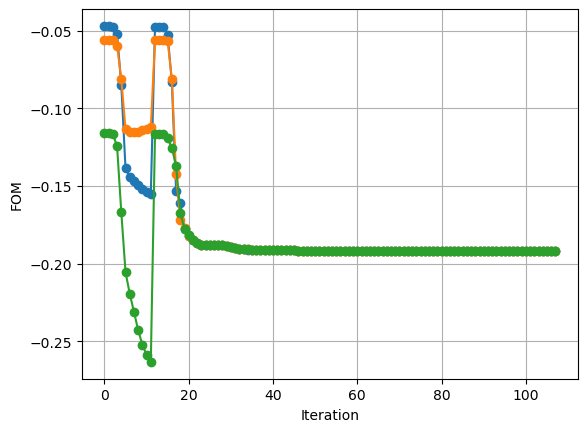

In [21]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

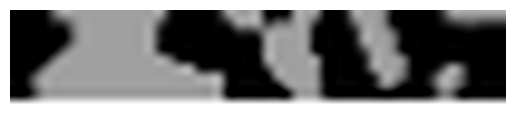

In [22]:
# opt[0].update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt[0].plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

FloatProgress(value=0.0, description='0% done ', max=200.0)

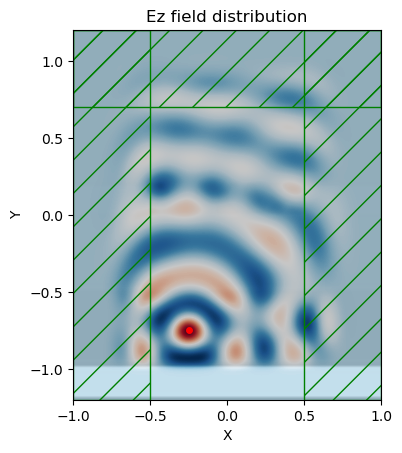

FloatProgress(value=0.0, description='0% done ', max=200.0)

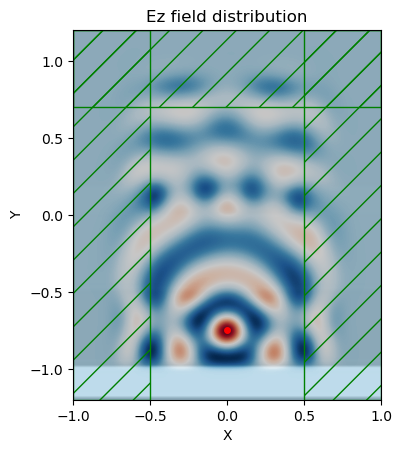

FloatProgress(value=0.0, description='0% done ', max=200.0)

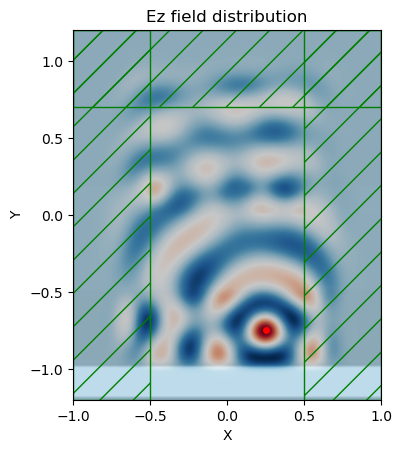

In [23]:
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )
ppopt =[]
for i in range(src_num):
    ppopt.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[source[i]],
                      extra_materials=[ALU],)
    )

for i in range(src_num):
    ppopt[i].run(until=200)
    ppopt[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.show()

In [24]:
flux_srcbox_top =[0]*src_num
flux_srcbox_bot =[0]*src_num
flux_srcbox_left =[0]*src_num
flux_srcbox_right =[0]*src_num

flux_glass =[0]*src_num
flux_wvgbox_right =[0]*src_num
flux_wvgbox_left =[0]*src_num

flux_total_srcbox =[0]*src_num
flux_total_glass =[0]*src_num
flux_waveguide =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

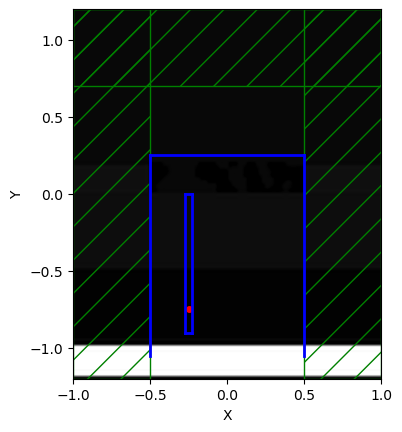

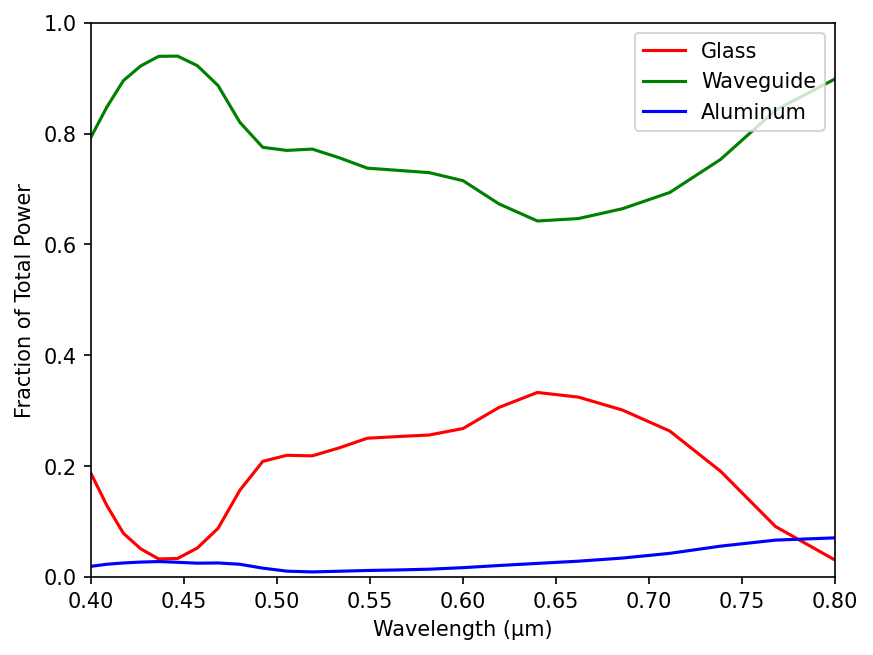

FloatProgress(value=0.0, description='0% done ')

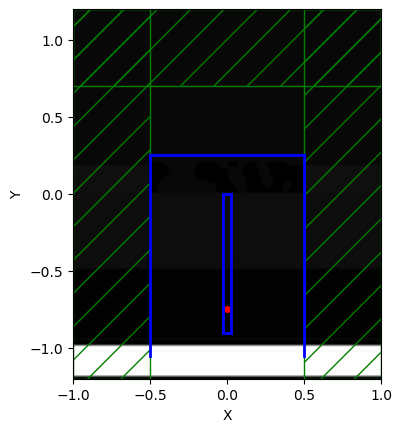

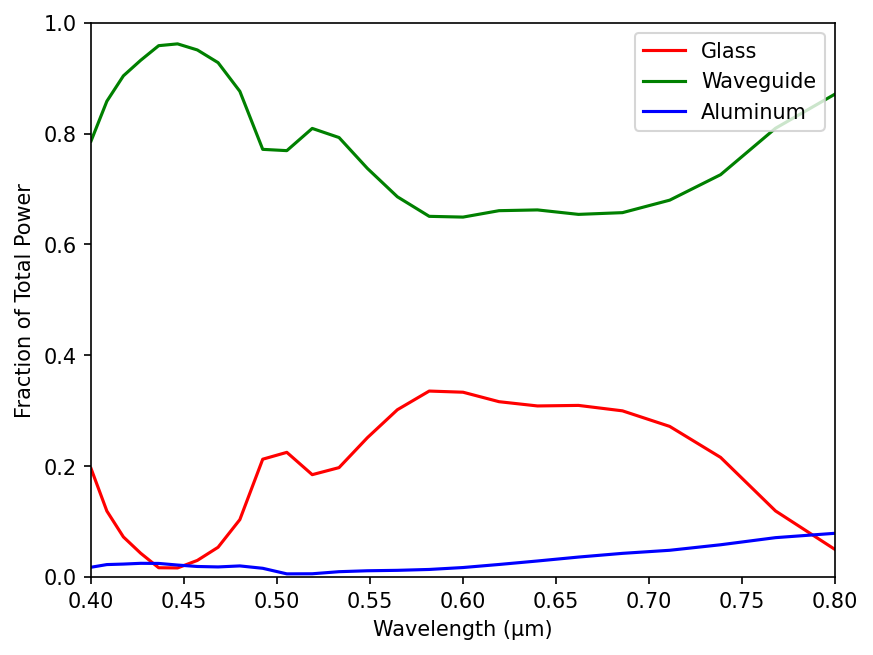

FloatProgress(value=0.0, description='0% done ')

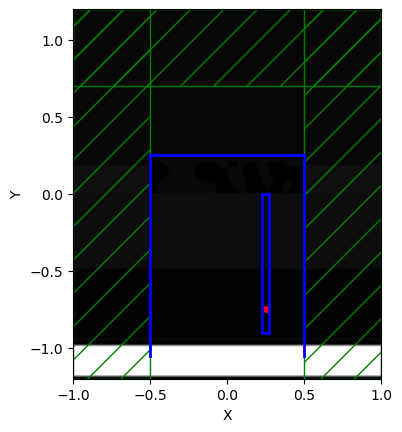

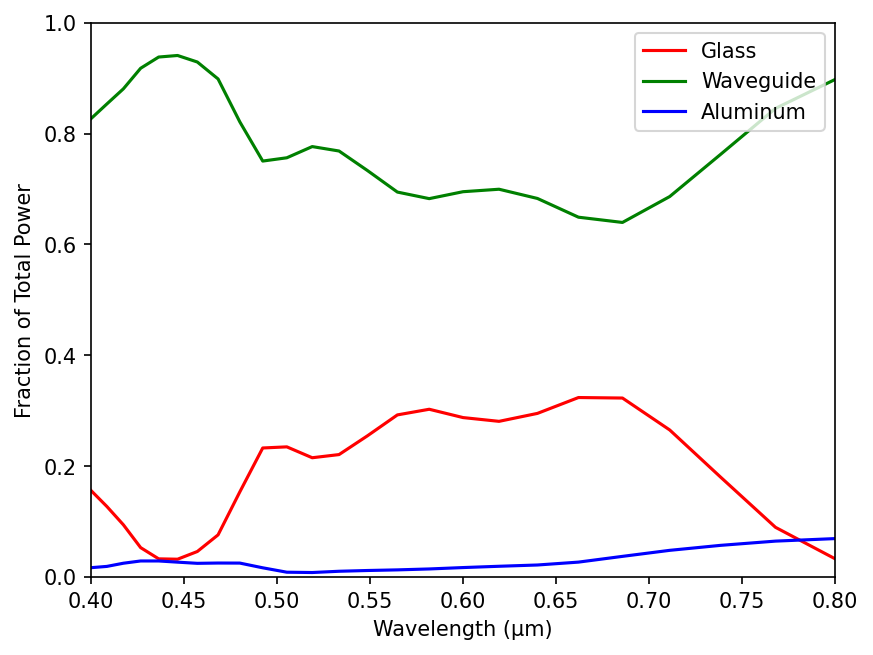

In [25]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glass[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_right[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_left[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcbox[i] = flux_srcbox_top[i] - flux_srcbox_bot[i] + flux_srcbox_right[i] - flux_srcbox_left[i]
    flux_total_glass[i] = flux_glass[i]
    flux_waveguide[i] = flux_wvgbox_right[i] - flux_wvgbox_left[i]

    wl = []
    gl = []
    wg = []
    al = []
    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_glass[i][d] / flux_total_srcbox[i][d])
        wg = np.append(wg, flux_waveguide[i][d] / flux_total_srcbox[i][d])
        al = 1 - gl - wg


    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Glass")
        plt.plot(wl, wg, "g", label="Waveguide")
        plt.plot(wl, al, "b", label="Aluminum")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.show()
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure




In [26]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

FloatProgress(value=0.0, description='0% done ', max=200.0)

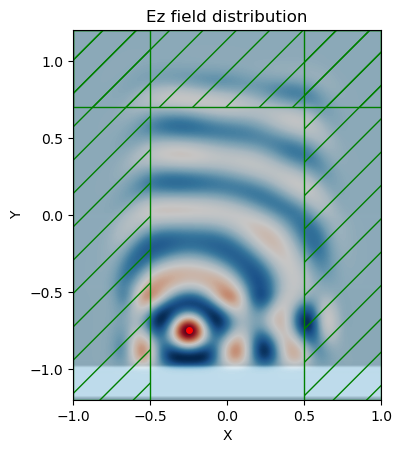

FloatProgress(value=0.0, description='0% done ', max=200.0)

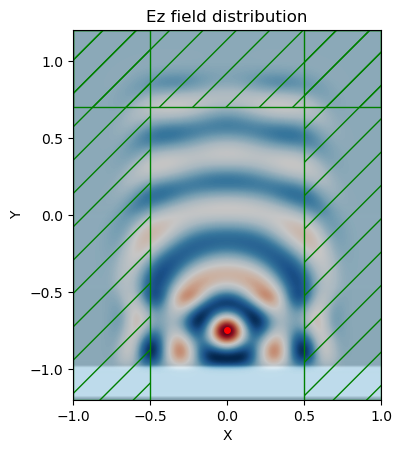

FloatProgress(value=0.0, description='0% done ', max=200.0)

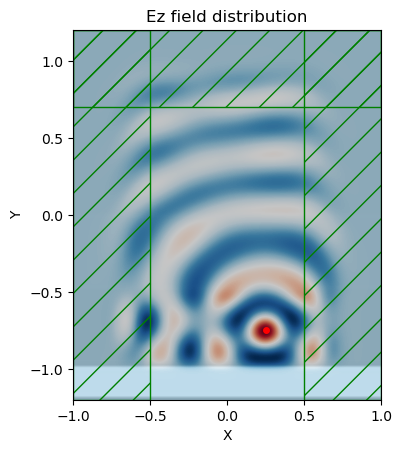

In [27]:
ppopto =[]
for i in range(src_num):
    ppopto.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometryo,
                      sources=[source[i]],
                      extra_materials=[ALU],)
    )

for i in range(src_num):
    ppopto[i].run(until=200)
    ppopto[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.show()

In [28]:
flux_srcbox_topo =[0]*src_num
flux_srcbox_boto =[0]*src_num
flux_srcbox_lefto =[0]*src_num
flux_srcbox_righto =[0]*src_num

flux_glasso =[0]*src_num
flux_wvgbox_righto =[0]*src_num
flux_wvgbox_lefto =[0]*src_num

flux_total_srcboxo =[0]*src_num
flux_total_glasso =[0]*src_num
flux_waveguideo =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

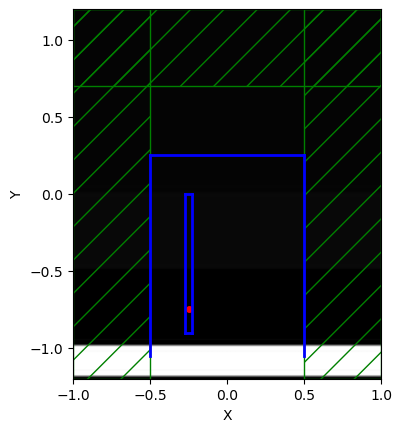

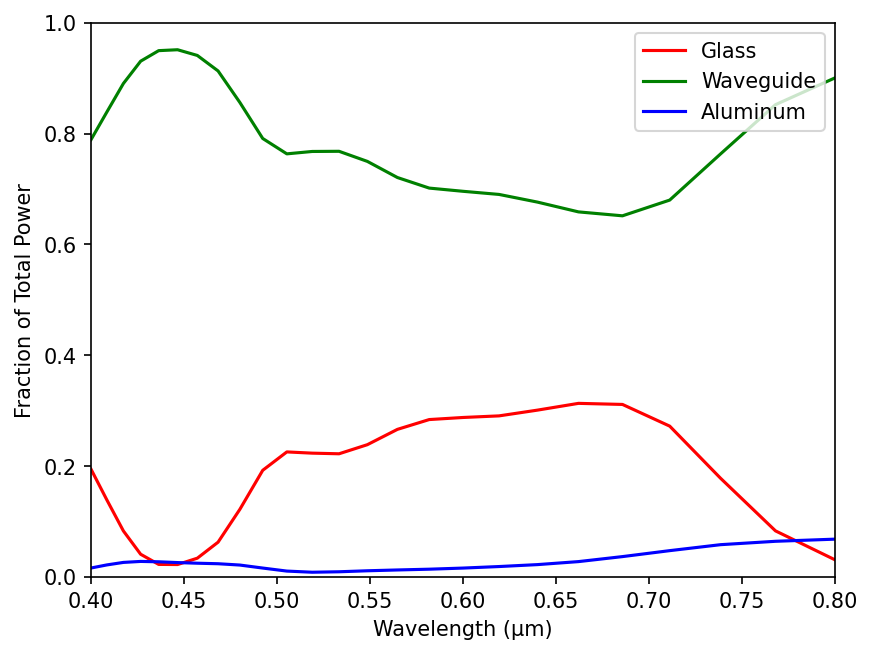

FloatProgress(value=0.0, description='0% done ')

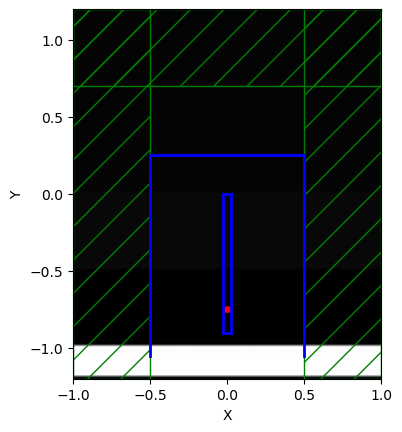

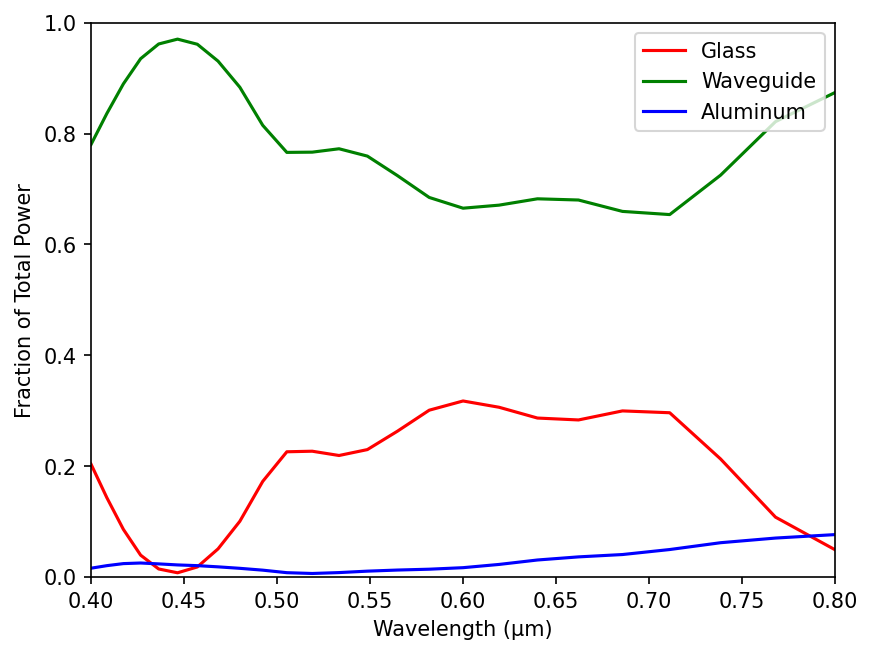

FloatProgress(value=0.0, description='0% done ')

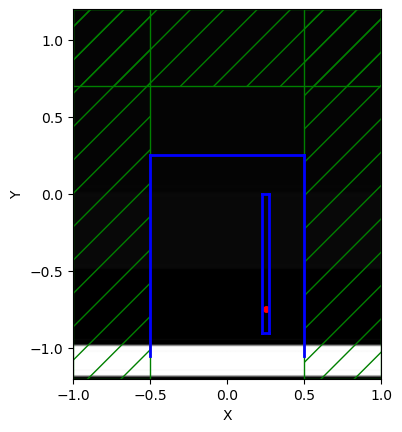

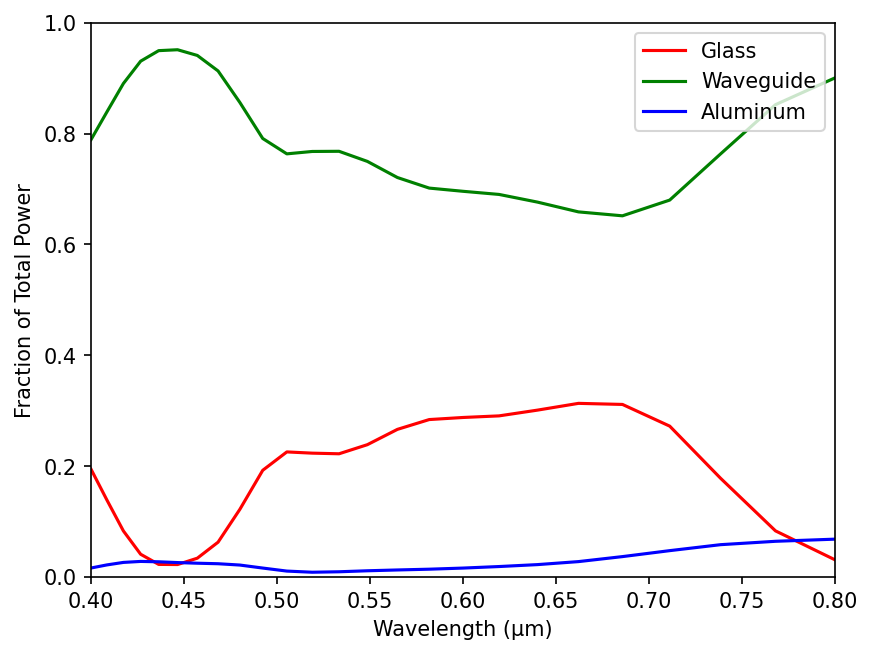

In [29]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glasso[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_righto[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_lefto[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcboxo[i] = flux_srcbox_topo[i] - flux_srcbox_boto[i] + flux_srcbox_righto[i] - flux_srcbox_lefto[i]
    flux_total_glasso[i] = flux_glasso[i]
    flux_waveguideo[i] = flux_wvgbox_righto[i] - flux_wvgbox_lefto[i]

    wl = []
    gl = []
    wg = []
    al = []
    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_glasso[i][d] / flux_total_srcboxo[i][d])
        wg = np.append(wg, flux_waveguideo[i][d] / flux_total_srcboxo[i][d])
        al = 1 - gl - wg


    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Glass")
        plt.plot(wl, wg, "g", label="Waveguide")
        plt.plot(wl, al, "b", label="Aluminum")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.show()
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure

In [30]:
flux_srcbox_top_s =[0]*src_num
flux_srcbox_bot_s =[0]*src_num
flux_srcbox_left_s =[0]*src_num
flux_srcbox_right_s =[0]*src_num

flux_glass_s =[0]*src_num
flux_wvgbox_right_s =[0]*src_num
flux_wvgbox_left_s =[0]*src_num

flux_total_srcbox_s =[0]*src_num
flux_total_glass_s =[0]*src_num
flux_waveguide_s =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

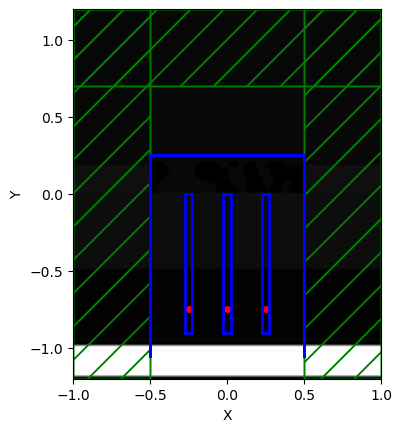

In [31]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glass_s[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_right_s[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_left_s[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcbox_s[i] = flux_srcbox_top_s[i] - flux_srcbox_bot_s[i] + flux_srcbox_right_s[i] - flux_srcbox_left_s[i]
    flux_total_glass_s[i] = flux_glass_s[i]
    flux_waveguide_s[i] = flux_wvgbox_right_s[i] - flux_wvgbox_left_s[i]



In [32]:
flux_srcbox_topo_s =[0]*src_num
flux_srcbox_boto_s =[0]*src_num
flux_srcbox_lefto_s =[0]*src_num
flux_srcbox_righto_s =[0]*src_num

flux_glasso_s =[0]*src_num
flux_wvgbox_righto_s =[0]*src_num
flux_wvgbox_lefto_s =[0]*src_num

flux_total_srcboxo_s =[0]*src_num
flux_total_glasso_s =[0]*src_num
flux_waveguideo_s =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

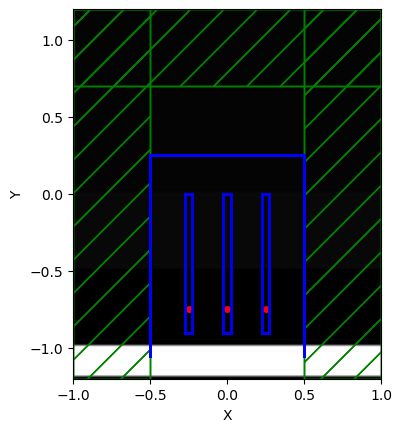

In [33]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glasso_s[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_righto_s[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_lefto_s[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcboxo_s[i] = flux_srcbox_topo_s[i] - flux_srcbox_boto_s[i] + flux_srcbox_righto_s[i] - flux_srcbox_lefto_s[i]
    flux_total_glasso_s[i] = flux_glasso_s[i]
    flux_waveguideo_s[i] = flux_wvgbox_righto_s[i] - flux_wvgbox_lefto_s[i]


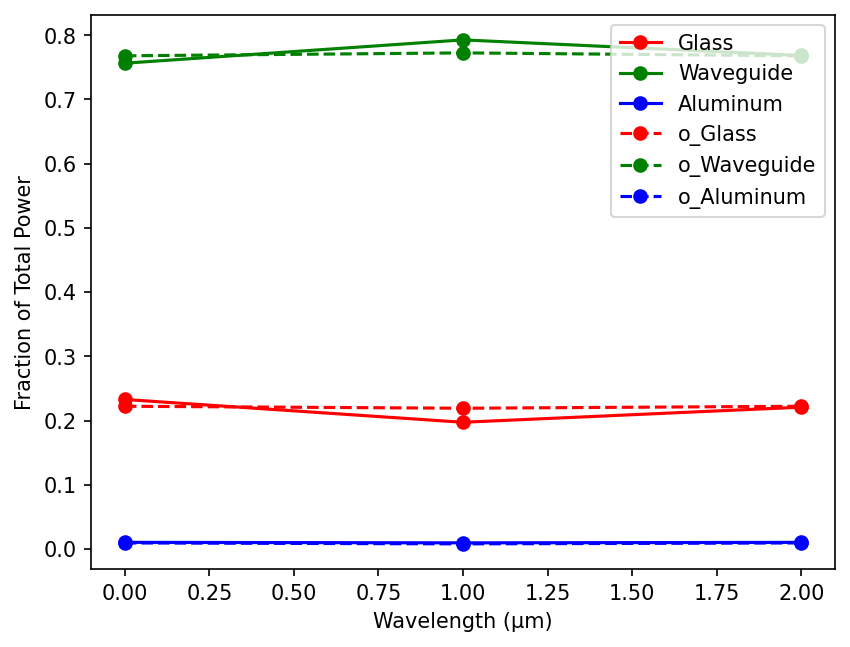

In [34]:
wl = []
gl = []
wg = []
al = []
o_gl = []
o_wg = []
o_al = []
for d in range(src_num):
    wl = np.append(wl, d)
    gl = np.append(gl, flux_total_glass_s[d] / flux_total_srcbox_s[d])
    wg = np.append(wg, flux_waveguide_s[d] / flux_total_srcbox_s[d])
    al = 1 - gl - wg
    o_gl = np.append(o_gl, flux_total_glasso_s[d] / flux_total_srcboxo_s[d])
    o_wg = np.append(o_wg, flux_waveguideo_s[d] / flux_total_srcboxo_s[d])
    o_al = 1 - o_gl - o_wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r-o", label="Glass")
    plt.plot(wl, wg, "g-o", label="Waveguide")
    plt.plot(wl, al, "b-o", label="Aluminum")
    plt.plot(wl, o_gl, "r--o", label="o_Glass")
    plt.plot(wl, o_wg, "g--o", label="o_Waveguide")
    plt.plot(wl, o_al, "b--o", label="o_Aluminum")

    
    # plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [35]:
print(flux_total_glass_s)

[array([0.12505492]), array([0.10452717]), array([0.11487138])]


In [36]:
print(flux_total_glasso_s)

[array([0.11485976]), array([0.11746403]), array([0.11485976])]
